## Replicative aging curves

From 20200320_byc, 20190726_byc

In [1]:
import scipy

In [78]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import tkinter as tk
import tkinter.filedialog as tkdia
from byc import standard_analysis as sa
from byc import files as fm

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
import seaborn as sns
from read_roi import read_roi_file, read_roi_zip

from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
import lifelines.datasets as ld
import scipy.optimize as opt

wbf = WeibullFitter()
kmf = KaplanMeierFitter()

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [3]:
def survival_fit(table):

    T = table['rls']
    E = table['observed']

    kmf.fit(T, event_observed=E)
    wbf.fit(T, event_observed=E)

    x_kmf = kmf.survival_function_.index
    y_kmf = kmf.survival_function_.values

    x_wbf = np.arange(0, T.max()+1, 1)
    y_wbf = wbf.survival_function_at_times(x_wbf)
    
    keys = ['y_kmf', 'x_kmf', 'x_wbf', 'y_wbf']
    data = [y_kmf, x_kmf, x_wbf, y_wbf]
    
    fit_dict = dict(zip(keys, data))
    
    return fit_dict

path = r"C:\Users\John Cooper\Projects\byc\data\20200320_byc\20200320_byc_analysis\Survival_Data_all.csv"
rpn4d_survival_df = pd.read_csv(path)

path = r"C:\Users\John Cooper\Projects\byc\data\20190726_byc\20190726_byc_analysis\retention_and_survival\Survival_Data_all.csv"
by4741_survival_df = pd.read_csv(path)

rpn4d_fit = survival_fit(rpn4d_survival_df)
by4741_fit = survival_fit(by4741_survival_df)

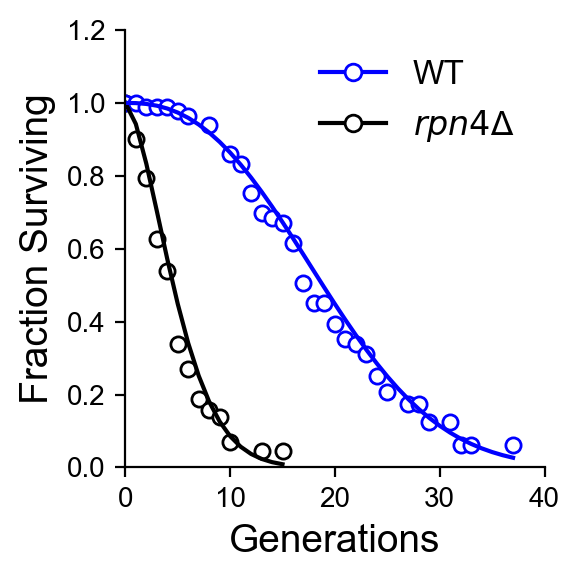

In [25]:
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()
size = 30
hidden_spines = ['top', 'right']

ax.scatter(rpn4d_fit['x_kmf'], rpn4d_fit['y_kmf'], color='black',
           s=size, facecolor='white')
ax.scatter(by4741_fit['x_kmf'], by4741_fit['y_kmf'], color='blue',
           s=size, facecolor='white')

ax.plot(rpn4d_fit['x_wbf'], rpn4d_fit['y_wbf'], color='black')
ax.plot(by4741_fit['x_wbf'], by4741_fit['y_wbf'], color='blue')

# Y axis settings
ax.set_ylim(0, 1.2)
ax.set_ylabel('Fraction Surviving', fontsize=14)

# X axis settings
ax.set_xlabel('Generations', fontsize=14)
ax.set_xlim(0, 40)

legend_elements = [Line2D([0], [0], marker='o', color='blue', label='WT',
                          markerfacecolor='w', markersize=6),
                  Line2D([0], [0], marker='o', color='black', label='$\it{rpn4}$\u0394',
                          markerfacecolor='w', markersize=6)]
ax.legend(handles=legend_elements, frameon=False, fontsize=12)

# Remove spines
for spine in [ax.spines[s] for s in hidden_spines]:
    spine.set_visible(False)
    
# Save figure
plt.tight_layout()
fig.savefig('Survival_Curves.svg')

## Representative cell trace with chase and bud annotation

See 20190726_byc_analysis.ipynb

In [79]:
from importlib import reload
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
# Plotting tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# Stats analysis tools
from scipy.stats import shapiro
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
# byc modules
from byc import plotting
import byc.standard_analysis as sa
import byc.fitting_tools as ft
import byc.files as fm
import byc.database as db
import byc.trace_tools as tt
# Set styles
plotting.set_styles(plt, matplotlib)

reloads = [sa, ft, plotting,
           fm, db, tt]
for module in reloads:
    reload(module)
byc_database = db.byc_database
db_df = byc_database.trace_database_df
expt_names = db_df.expt_name.unique()
expt_names

array(['20191106_byc_by4741_young_NS',
       '20191223_byc_by4741_Rkk-Su9_pJC034',
       '20191213_byc_by4741_young_rkk-sp2_pJC033',
       '20190927_byc_rpn4d_young_ubl-yfp-ns_pJC010',
       '20190927_byc_rpn4d_old_ubl-yfp-ns_pJC010',
       '20190920_byc_pJC010_UbL_YFP_NS_pdr5d_old',
       '20191008_byc_pJC010_UbL_YFP_NS_pdr5d_young',
       '20191008_byc_pJC010_UbL_YFP_NS_ubr2d_young',
       '20190726_byc_pJC010_UBL-YFP-NS_pdr5d_young_old_decay'],
      dtype=object)

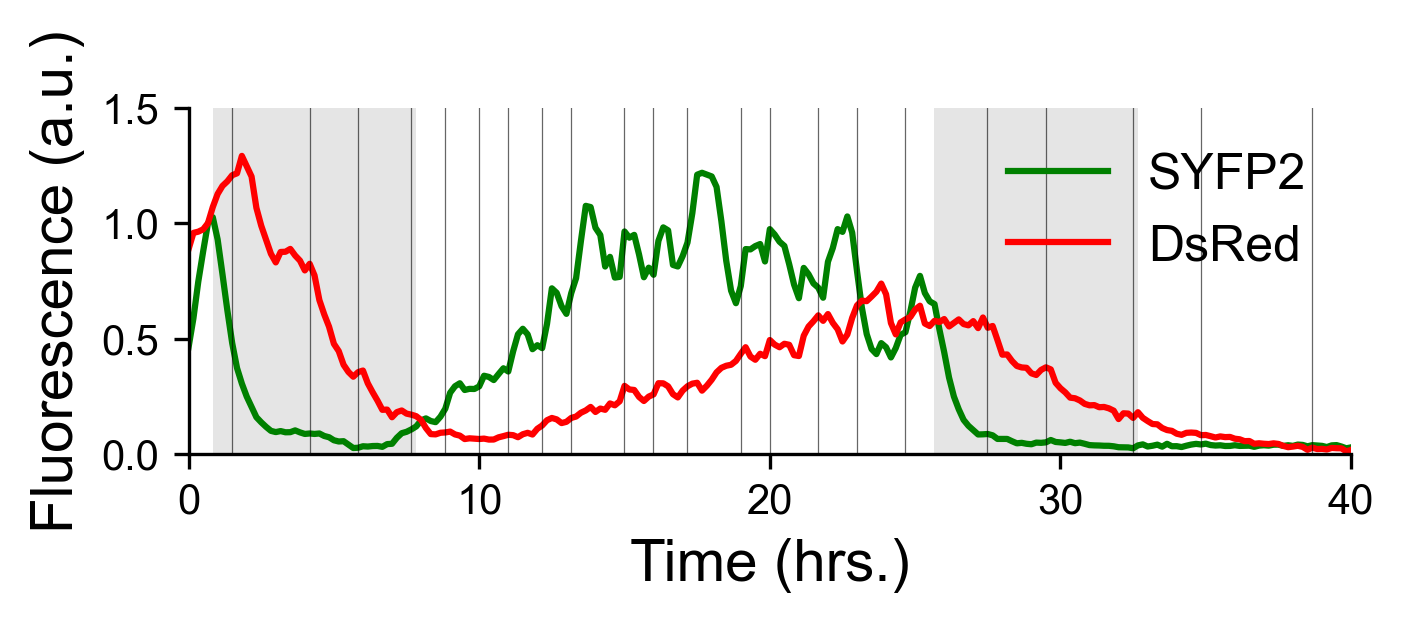

In [99]:
# get traces from 20190726_byc, a long experiment
expt_name = "20190726_byc_pJC010_UBL-YFP-NS_pdr5d_young_old_decay"

dfs_list = byc_database.get_cell_trace_dfs(expt_name)

cell_index = 3

expt_df = byc_database.trace_database_df[byc_database.trace_database_df.expt_name == expt_name]
path = expt_df.loc[expt_df.index[cell_index], 'bud_roi_path']
manual_bud_indices = fm.read_roi_position_indices(path)
cell_buds_hrs =  (manual_bud_indices*0.1666)-0.1666

cell_trace_df = dfs_list[cell_index]
# Make data
chase_frame_1 = 4
x = cell_trace_df.hours
yfp = cell_trace_df.yfp_mean - cell_trace_df.yfp_mean.min()
yfp = yfp/yfp[chase_frame_1]
rfp = cell_trace_df.dsred_mean - cell_trace_df.dsred_mean.min()
rfp = rfp/rfp[chase_frame_1]
# Plot settings
fig = plt.figure(figsize=(5,1.5))
fig.set_dpi(300)
hidden_spines = ['top', 'right']
y_color = 'green'
r_color = 'red'
# Setting axes
ax = plt.axes()
ax.set_xlim(0, 40)
ax.set_xticks(np.arange(0, 50, 10))
ax.set_xlabel('Time (hrs.)', fontsize=14)
ax.set_ylim(0, 1.5)
ax.set_ylabel('Fluorescence (a.u.)', fontsize=14)
# Remove spines
for spine in [ax.spines[s] for s in hidden_spines]:
    spine.set_visible(False)
    
# Legend
legend_elements = [Line2D([0], [0], color=y_color, label='SYFP2'),
                  Line2D([0], [0], color=r_color, label='DsRed')]
ax.legend(handles=legend_elements, frameon=False, fontsize=12)
# Plotting
# Traces
ax.plot(x, yfp, color=y_color)
ax.plot(x, rfp, color=r_color)
# Bud annotations
for bud in cell_buds_hrs:
    ax.axvline(bud, linewidth=0.3, color='black', alpha=0.6)
    
# Chase timepoints
x_fill = np.arange((chase_frame_1+1)*0.166, (chase_frame_1+1)*0.166 + 8)
y1_fill = 0
y2_fill = 1.5
ax.fill_between(x_fill, y1_fill, y2_fill, facecolor='gray', alpha=0.2)

x_fill = np.arange(25.66, 25.66 + 8)
y1_fill = 0
y2_fill = 1.5
ax.fill_between(x_fill, y1_fill, y2_fill, facecolor='gray', alpha=0.2)
fig.savefig('Chase_cell_trace.svg')

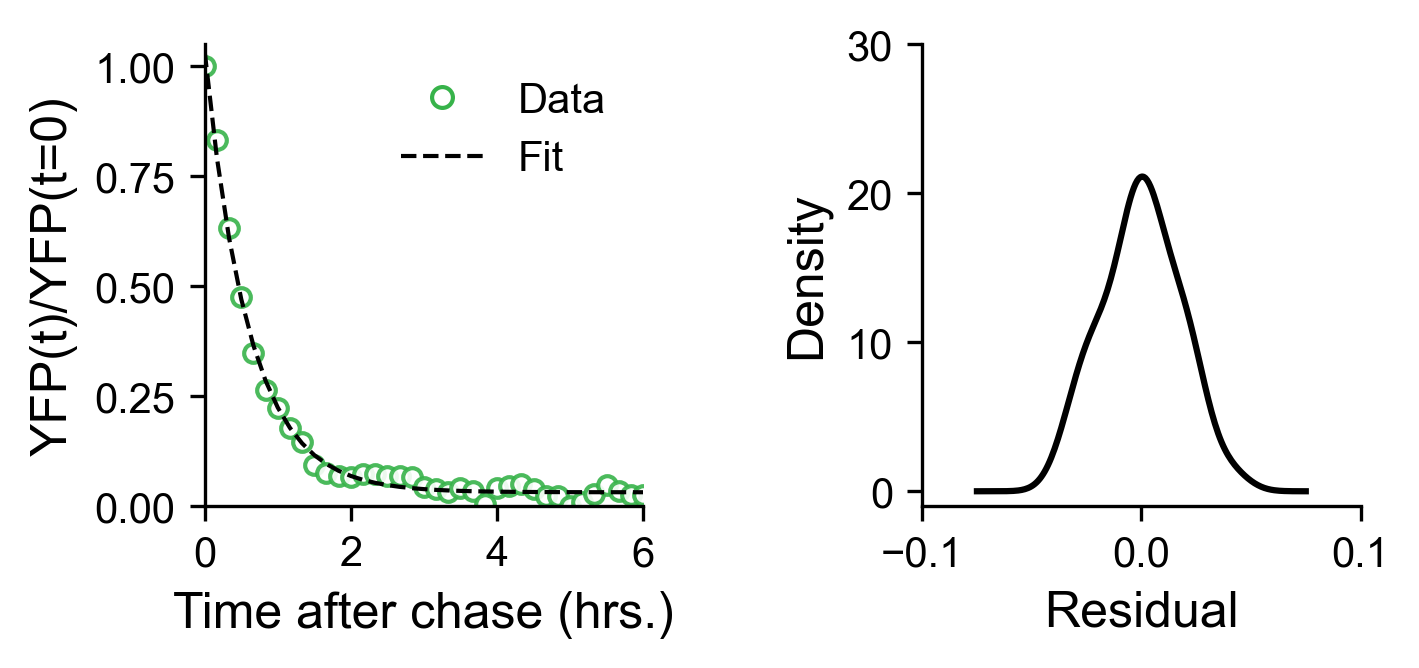

In [149]:
dfs_list = byc_database.get_cell_trace_dfs(expt_name)
fits_df = ft.get_all_fits_df(dfs_list, 5, window_size=36, fit_func=ft.single_exp, col_name='yfp_mean')
df = fits_df.loc[fits_df.cell_index==0, :]

save = False
x = df.x_input
y = df.y_input_norm
figsize = (6, 2)
width = figsize[0]
height = figsize[1]
fontsize = 12
hidden_spines = ['top', 'right']

fig = plt.figure(figsize=figsize, tight_layout=False)
fig.set_dpi(300)

grid = plt.GridSpec(figsize[1], figsize[0])

xlim = (0, 6)
ylim = (0, 1.05)
xlim_hist = (0.5, 0.5)
ylim_hist = (0, 10)
ax1 = fig.add_subplot(grid[:, 0:2])
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_ylabel('YFP(t)/YFP(t=0)', fontsize=fontsize)
ax1.set_xlabel('Time after chase (hrs.)', fontsize=fontsize)

ax1.scatter(x, y,
            color='w',
            edgecolor='#37B34A',
            s=20,
            alpha=0.9)

ax1.plot(x, df.y_pred_norm,
         color='black',
         linestyle='--',
         linewidth=1)

# Line plot legend
custom_lines = [Line2D([0], [0],
                       marker='o',
                       color='w',
                       markerfacecolor='w',
                       markersize=5,
                       markeredgecolor='#37B34A'),
                Line2D([0], [0],
                       lw=1,
                       linestyle='--',
                       color='black')]

ax1.legend(custom_lines,
           ['Data', 'Fit'],
           frameon=False,
           loc='upper right')

# Histogram part
ax2 = fig.add_subplot(grid[:, 3:5])
ax2.set_ylabel('Density', fontsize=fontsize)
ax2.set_xlabel('Residual', fontsize=fontsize)

density = gaussian_kde(df.residual)
xs = np.linspace(-0.075,0.075,200)
ax2.plot(xs, density(xs), color='black')
ax2.set_xlim(-0.1, .1)
ax2.set_ylim(-1, 30)

# Remove spines
for spine in [ax1.spines[n] for n in hidden_spines]:
    spine.set_visible(False)
    
for spine in [ax2.spines[n] for n in hidden_spines]:
    spine.set_visible(False)

fig.savefig('Fit_and_residuals.svg')

## Rate vs. Aging plots
See analysis from 20191008_byc

In [156]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tkinter as tk
import tkinter.filedialog as tkdia
import byc.standard_analysis as sa

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from read_roi import read_roi_file, read_roi_zip

from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
import lifelines.datasets as ld
import scipy.optimize as opt

wbf = WeibullFitter()
kmf = KaplanMeierFitter()

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [157]:
rpn4d_df_path = r"C:\Users\John Cooper\Projects\byc\data\20191008_byc\20191008_byc_analysis\20190927_rpn4delta_old_NS_fits_df.csv"
rpn4d_old_fits_df = pd.read_csv(rpn4d_df_path)

pdr5d_df_path = r"C:\Users\John Cooper\Projects\byc\data\20191008_byc\20191008_byc_analysis\20190920_byc_old_decay_fit_params_df.csv"
pdr5d_old_fits_df = pd.read_csv(pdr5d_df_path)

In [162]:
yasdasd

0     2.091316
1     0.844159
2     0.765844
3     1.428257
4     2.286887
5     2.488138
6     1.405447
7     2.366891
8     1.783509
9     1.501336
10    3.368587
11    1.349408
12    1.772601
13    1.707465
14    2.059569
15    1.882154
16    2.279620
17    2.584888
18    2.181755
19    2.435950
20    2.312633
21    1.790910
22    1.759321
23    2.051117
24    1.741080
25    1.579682
26    1.600787
27    2.163127
28    1.763575
29    1.964681
30    1.735954
31    1.623657
32    1.556750
33    1.584554
34    2.030017
35    1.959058
36    1.651184
37    2.034563
Name: b_norm, dtype: float64

In [165]:
X.reshape((len(X), 0))

ValueError: cannot reshape array of size 38 into shape (38,0)

In [166]:
from scipy.stats import linregress

In [175]:
def linear_function(x, slope, intercept):
    y = slope*x + intercept
    return y

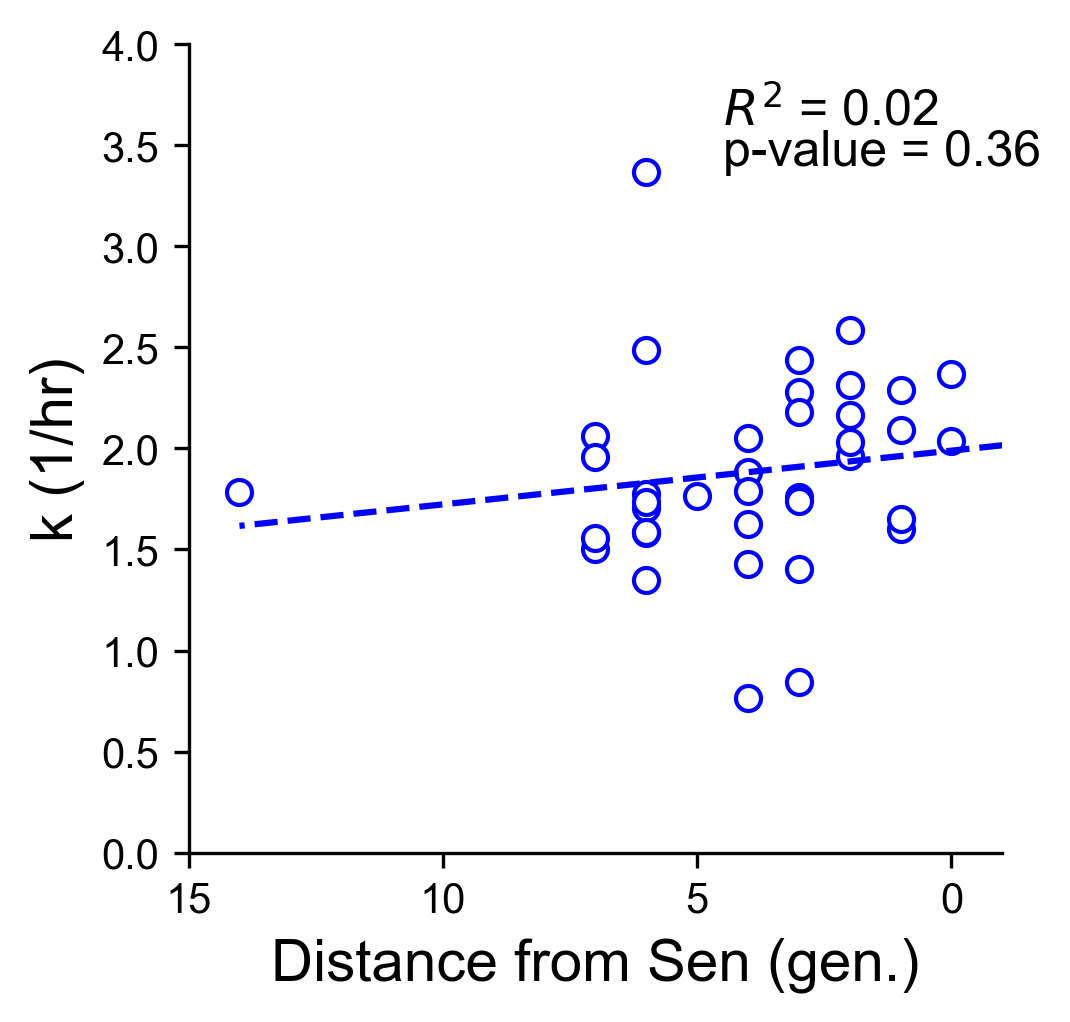

In [194]:
df = pdr5d_old_fits_df
start_x_at_zero = False

x = df['dist_from_sen']
y = df['b_norm']

linewidth = 1
alpha = 0.6
color = 'blue'
x_interval = 5
y_interval = 0.5
x_lim = (-1, 15)
y_lim = (0, 4)

if start_x_at_zero:
    x_lim[0] = 0
else:
    pass

fig = plt.figure(figsize=(3.5, 3.5))
fig.set_dpi(300)

ax = plt.axes()
ax.margins(0, 0)
ax.set_ylabel('k (1/hr)', fontsize=14)
ax.set_xlabel('Distance from Sen (gen.)', fontsize=14)

ax.set_ylim(y_lim[0], y_lim[1])

ax.set_xlim(x_lim[1], x_lim[0])

ax.scatter(x, y, color=color, marker='o', facecolor='white')

# Compute linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_sq = r_value*r_value
# generate predicted data to plot
x_pred = np.arange(x_lim[0], x_lim[1], 0.1*x_lim[1])
y_pred = linear_function(x_pred, slope, intercept)
ax.plot(x_pred, y_pred, linestyle='--', color=color)
#ax.fill_between(x, y_pred-mse, y_pred+mse, facecolor='blue', alpha=0.2)
r_sqstr = r'$R^{2}$'
ax.annotate(f"{r_sqstr} = {(str(r_sq)[0:4])}", (0.3*x_lim[1], 0.9*y_lim[1]), fontsize=12)
ax.annotate('p-value = {}'.format(str(p_value)[0:4]), (0.3*x_lim[1], 0.85*y_lim[1]), fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig("pdr5d_old_b_vs_dist_from_sen.svg")

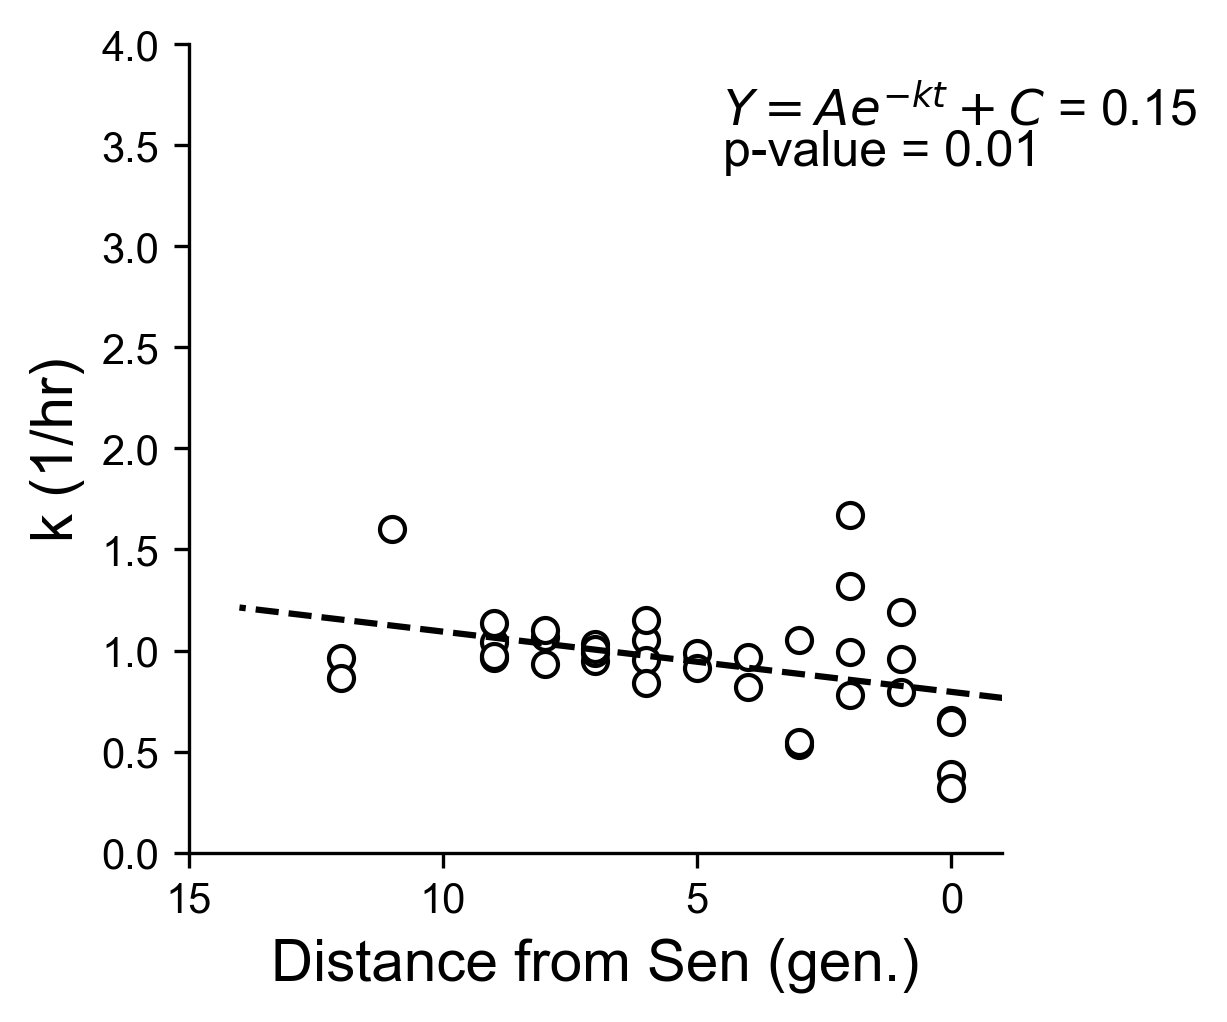

In [198]:
df = rpn4d_old_fits_df
start_x_at_zero = False

x = df['dist_from_sen']
y = df['b_norm']

linewidth = 1
alpha = 0.6
color = 'black'
x_interval = 5
y_interval = 0.5

x_lim = (-1, 15)
y_lim = (0, 4)

if start_x_at_zero:
    x_lim[0] = 0
else:
    pass

fig = plt.figure(figsize=(3.5, 3.5))
fig.set_dpi(300)

ax = plt.axes()
ax.margins(0, 0)
ax.set_ylabel('k (1/hr)', fontsize=14)
ax.set_xlabel('Distance from Sen (gen.)', fontsize=14)

# ax.set_yticks(np.arange(y_lim[0], y_lim[1]+1, y_interval))
ax.set_ylim(y_lim[0], y_lim[1])

# ax.set_xticks(np.arange(x_lim[0], x_lim[1]+1, x_interval))
ax.set_xlim(x_lim[1], x_lim[0])

ax.scatter(x, y, color=color, marker='o', facecolor='white')

# Compute linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_sq = r_value*r_value
# generate predicted data to plot
x_pred = np.arange(x_lim[0], x_lim[1], 0.1*x_lim[1])
y_pred = linear_function(x_pred, slope, intercept)
ax.plot(x_pred, y_pred, linestyle='--', color=color)
#ax.fill_between(x, y_pred-mse, y_pred+mse, facecolor='blue', alpha=0.2)
r_sqstr = r'$Y=Ae^{-kt} + C$'
ax.annotate(f"{r_sqstr} = {(str(r_sq)[0:4])}", (0.3*x_lim[1], 0.9*y_lim[1]), fontsize=12)
ax.annotate('p-value = {}'.format(str(p_value)[0:4]), (0.3*x_lim[1], 0.85*y_lim[1]), fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig("rpn4d_old_b_vs_dist_from_sen.svg")

## UPS-PQC substrates Rpn4d Sensitivity

In [137]:
import os
import numpy as np
import pandas as pd
from functools import reduce
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import matplotlib
from byc import steady_state_analysis as ssa
import tkinter as tk
import tkinter.filedialog as tkdia
import seaborn as sns
from scipy import stats
from scipy.stats import wilcoxon
plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [138]:
from importlib import reload
for mod in [ssa]:
    reload(mod)

In [139]:
inds_dir = r'C:\Users\John Cooper\Box Sync\Finkelstein-Matouschek\images\meta_analysis\Nuclear_Substrates'
master_index_fns = ['20200903_master_index.csv',
                    '20200917_master_index.csv',
                    '20200923_master_index.csv', 
                    '20200926_master_index.csv',
                    '20201009_master_index.csv']
master_index_paths = [os.path.join(inds_dir, fn) for fn in master_index_fns]

data_dfs = [ssa.make_expt_df(path, bg_channel='rfp', filter_cells=False) for path in master_index_paths]
alldf = pd.concat(data_dfs, sort=False, ignore_index=True)

In [140]:
subindex = pd.read_csv(os.path.join(inds_dir, 'Substrates_Index.csv'))

# normalizing to WT RFP/YFP
alldf.loc[:, 'rfp_yfp_wt_norm'] = 0

for name in [f'pJC{str(ind).zfill(3)}' for ind in subindex.CEN4_TetApt_Plasmid]:
    print(f'Normalizing to WT rfp_yfp for {name}')
    wt_med = alldf.loc[alldf.plasmid==name, 'rfp_yfp'].median()
    print(wt_med)
    norm_values = alldf.loc[alldf.plasmid==name, 'rfp_yfp']/wt_med
    alldf.loc[alldf.plasmid==name, 'rfp_yfp_wt_norm'] = norm_values

table = pd.pivot_table(alldf, values=['rfp_yfp', 'rfp_yfp_wt_norm'],
                       index=['plasmid', 'genotype', 'clone'], aggfunc=np.mean).reset_index()

plasmid_inds = [103, 71, 124, 102,
                101, 155,
                130, 135, 139]

labels = subindex.set_index('CEN4_TetApt_Plasmid').loc[plasmid_inds, 'Substrate_abbrev']

Normalizing to WT rfp_yfp for pJC103
0.9342671497770487
Normalizing to WT rfp_yfp for pJC071
0.362835558508313
Normalizing to WT rfp_yfp for pJC124
0.8895453456616017
Normalizing to WT rfp_yfp for pJC102
0.41877257692494685
Normalizing to WT rfp_yfp for pJC151
nan
Normalizing to WT rfp_yfp for pJC101
0.1353084841046154
Normalizing to WT rfp_yfp for pJC155
0.33546573795491075
Normalizing to WT rfp_yfp for pJC130
1.0785289202255914
Normalizing to WT rfp_yfp for pJC133
0.2998127565352529
Normalizing to WT rfp_yfp for pJC135
0.32640797785080583
Normalizing to WT rfp_yfp for pJC137
0.6440019414503543
Normalizing to WT rfp_yfp for pJC139
0.37104902426804726


In [32]:
ax.set_xticklabels?

### Aggregate bar plot

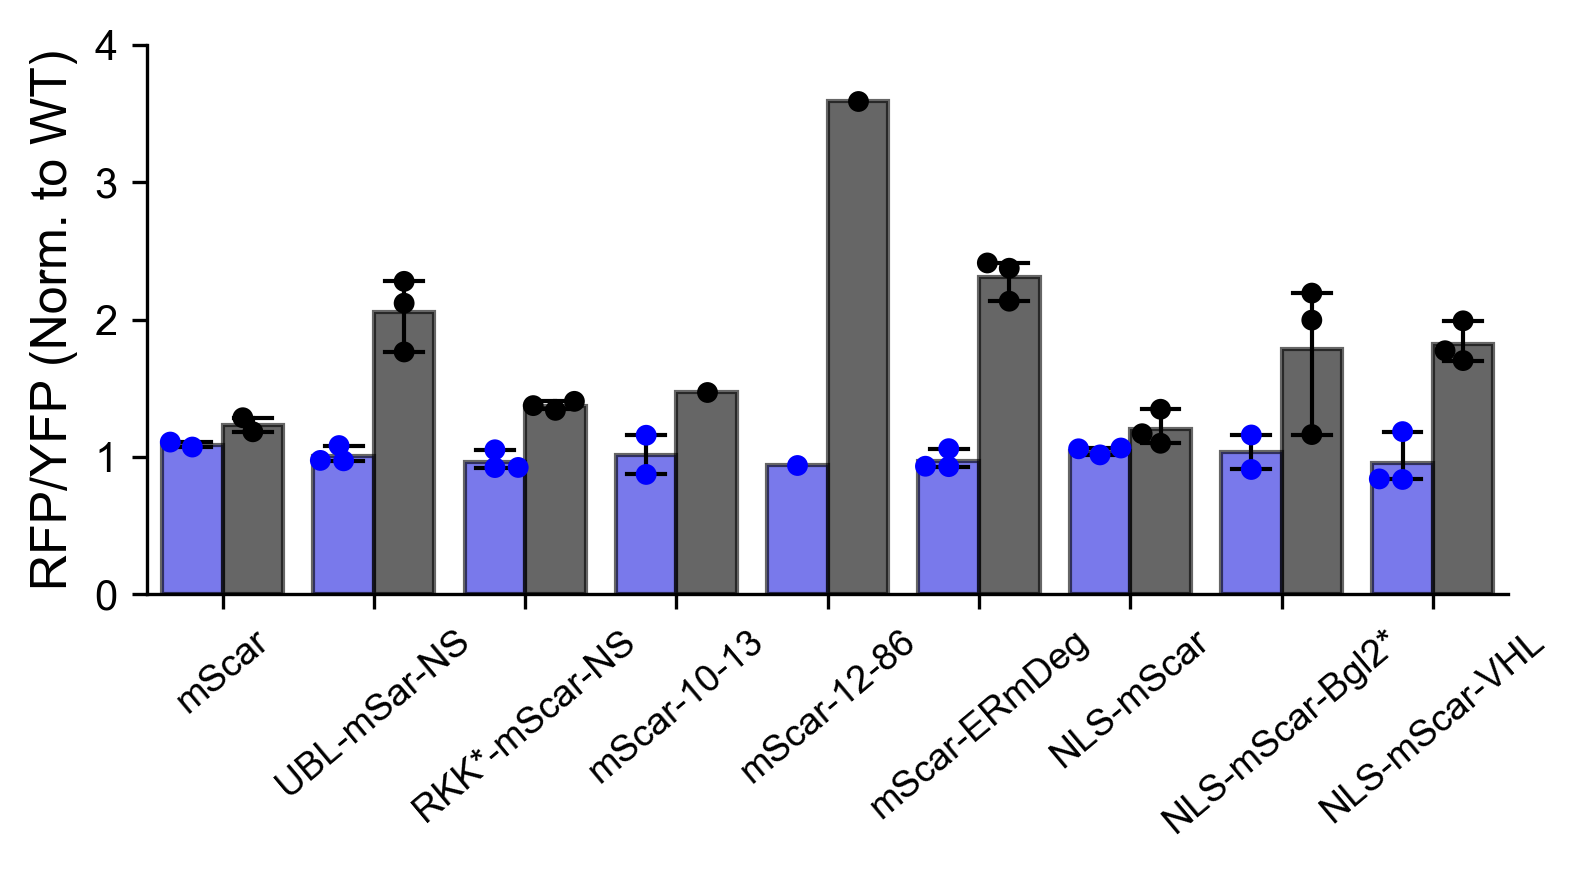

In [61]:
fig = plt.figure(figsize=(5.5, 3))
fig.set_dpi(300)

plasmid_names = ['pJC103', 'pJC071', 'pJC124', 'pJC102',
                 'pJC101', 'pJC155',
                 'pJC130', 'pJC135', 'pJC139']
yvar = 'rfp_yfp_wt_norm'
ylabel = 'RFP/YFP (Norm. to WT)'
ylim=(0, 4)
xlabel = ''
palette = ['blue', 'black']

df = table[table.plasmid.isin(plasmid_names)]

ax=sns.barplot(data=df, x='plasmid', y=yvar, hue='genotype',
               order=plasmid_names, dodge=True, palette=palette,
               errwidth=1, capsize=0.25, errcolor='black',
               alpha=0.6, edgecolor='black')

sns.swarmplot(data=df, x='plasmid', y=yvar, hue='genotype',
              order=plasmid_names, dodge=True, palette=palette,
              facecolor='white', 
              ax=ax)

sns.despine()
ax.set_ylim(ylim)
ax.get_legend().set_visible(False)
ax.set_ylabel(ylabel, fontsize=12)
ax.set_xlabel(xlabel)
ax.set_xticklabels(labels, fontsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(40)
plt.tight_layout()

fig.savefig('All_Substrates_bar_graph.svg')

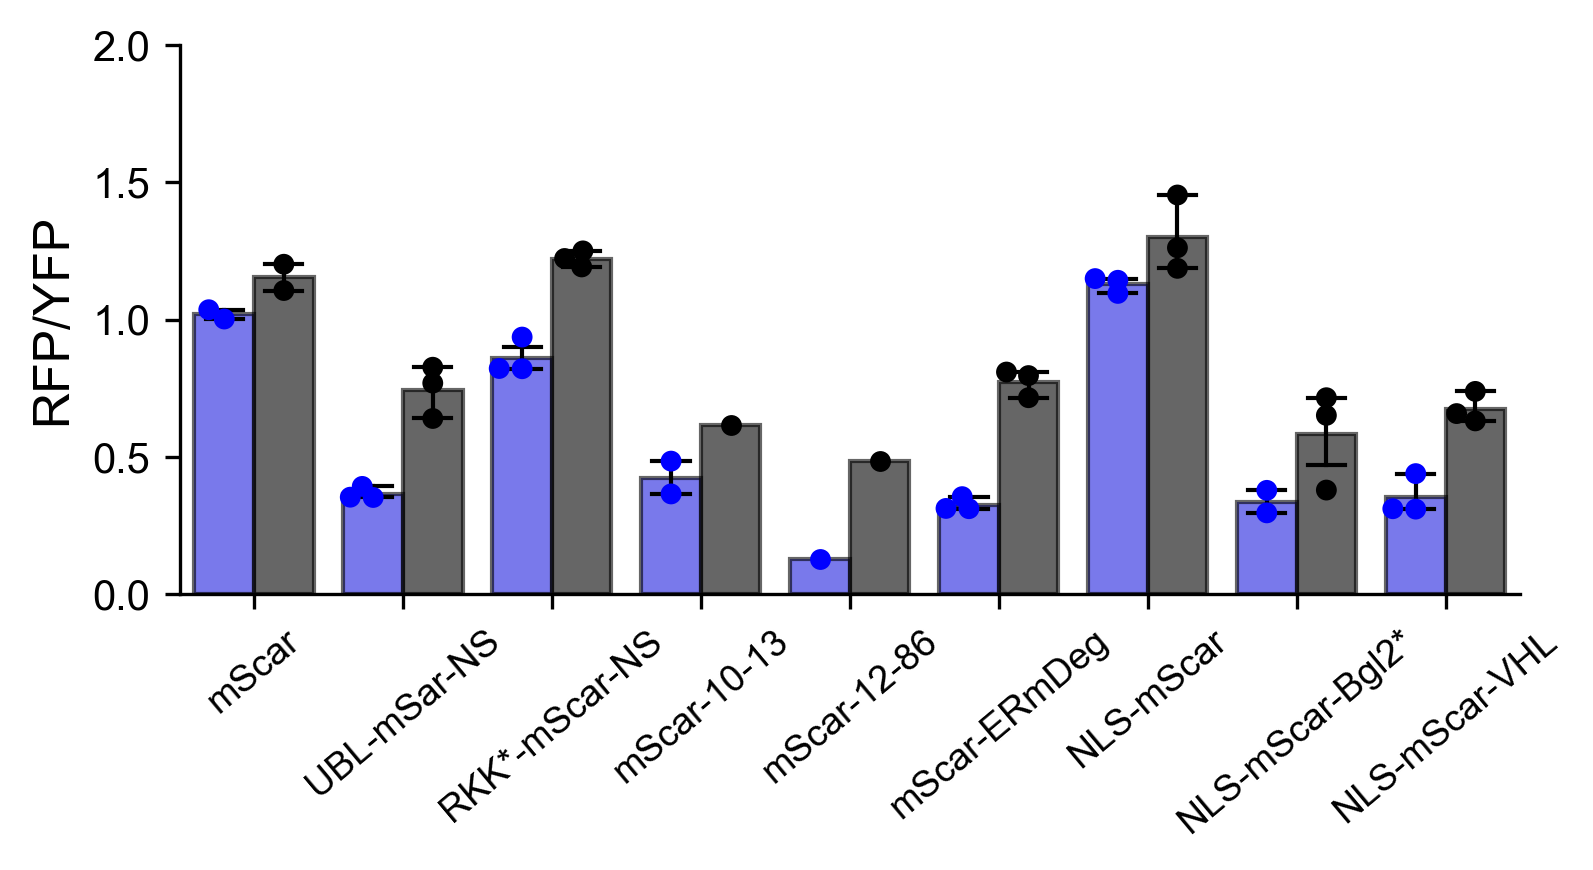

In [145]:
fig = plt.figure(figsize=(5.5, 3))
fig.set_dpi(300)

plasmid_names = ['pJC103', 'pJC071', 'pJC124', 'pJC102',
                 'pJC101', 'pJC155',
                 'pJC130', 'pJC135', 'pJC139']
yvar = 'rfp_yfp'
ylabel = 'RFP/YFP'
ylim=(0, 2)
xlabel = ''
palette = ['blue', 'black']

df = table[table.plasmid.isin(plasmid_names)]

ax=sns.barplot(data=df, x='plasmid', y=yvar, hue='genotype',
               order=plasmid_names, dodge=True, palette=palette,
               errwidth=1, capsize=0.25, errcolor='black',
               alpha=0.6, edgecolor='black')

sns.swarmplot(data=df, x='plasmid', y=yvar, hue='genotype',
              order=plasmid_names, dodge=True, palette=palette,
              facecolor='white', 
              ax=ax)

sns.despine()
ax.set_ylim(ylim)
ax.get_legend().set_visible(False)
ax.set_ylabel(ylabel, fontsize=12)
ax.set_xlabel(xlabel)
ax.set_xticklabels(labels, fontsize=9)
for label in ax.get_xticklabels():
    label.set_rotation(40)
plt.tight_layout()

fig.savefig('All_Substrates_bar_graph.svg')

### Non-aggregate swarm plot

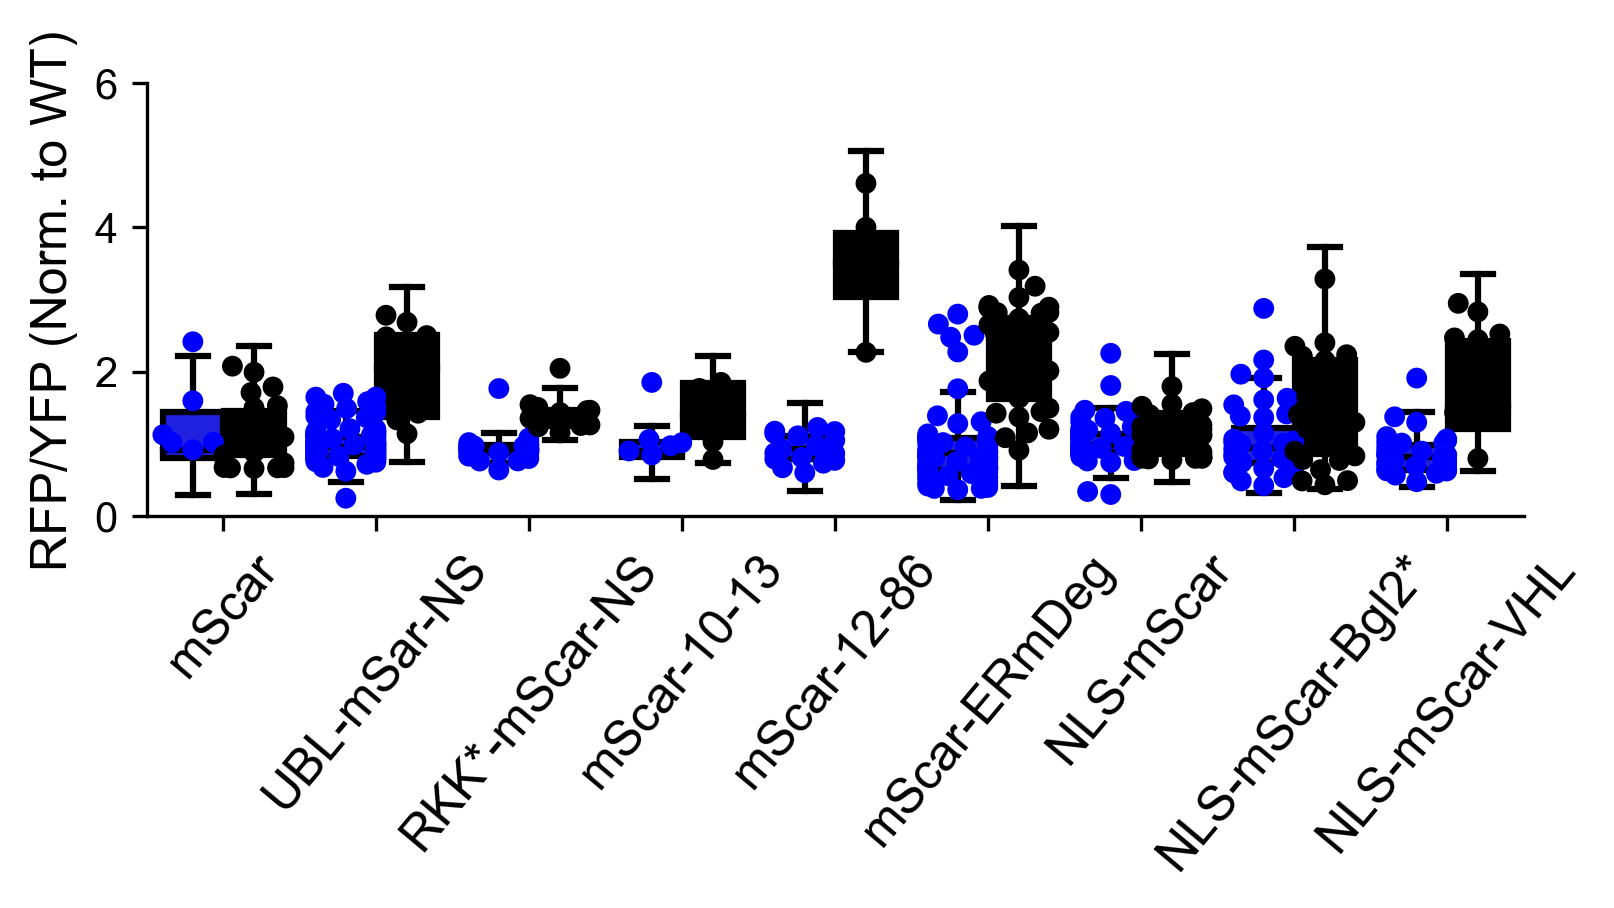

In [48]:
fig = plt.figure(figsize=(5.5, 3))
fig.set_dpi(300)

plasmid_names = ['pJC103', 'pJC071', 'pJC124', 'pJC102',
                 'pJC101', 'pJC155',
                 'pJC130', 'pJC135', 'pJC139']
yvar = 'rfp_yfp_wt_norm'
ylabel = 'RFP/YFP (Norm. to WT)'
ylim=(0, 6)
xlabel = ''
palette = ['blue', 'black']

df = alldf[alldf.plasmid.isin(plasmid_names)]

ax=sns.boxplot(data=df, x='plasmid', y=yvar, hue='genotype',
               order=plasmid_names, dodge=True, palette=palette,
               showfliers=False)

sns.swarmplot(data=df.sample(500), x='plasmid', y=yvar, hue='genotype',
              order=plasmid_names, dodge=True, palette=palette, 
              ax=ax)

sns.despine()
ax.set_ylim(ylim)
ax.get_legend().set_visible(False)
ax.set_ylabel(ylabel, fontsize=12)
ax.set_xlabel(xlabel)
ax.set_xticklabels(labels, fontsize=12)
for label in ax.get_xticklabels():
    label.set_rotation(50)
plt.tight_layout()

fig.savefig('All_Substrates_Box-Swarm_plot.svg')

### Simulating log effect on exponential decay

In [6]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from byc import fitting_tools

In [16]:
t = np.arange(0, 6, 0.1)
y = fitting_tools.single_exp(t, 1, 1.5, 0)

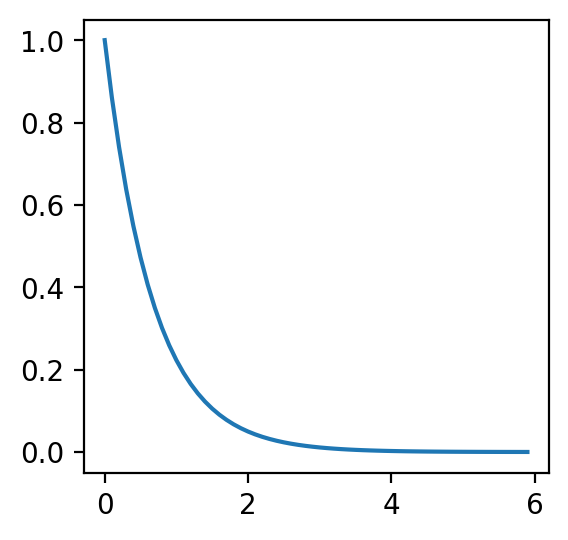

In [28]:
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = fig.add_subplot(111)

ax.plot(t, y)

<ipython-input-32-8a4d88ea1c2d>:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(t), y)


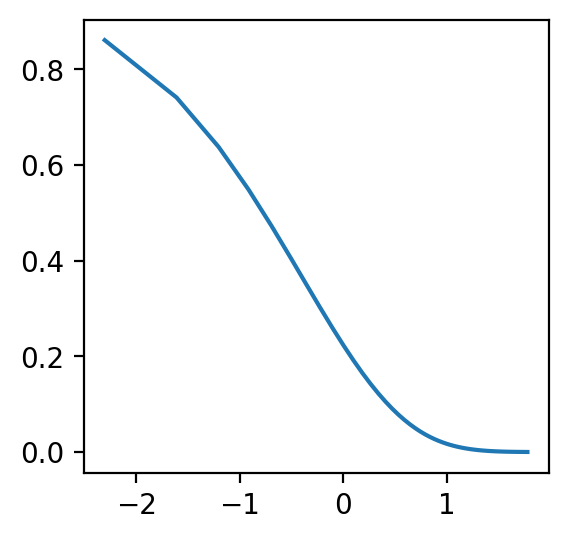

In [32]:
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = fig.add_subplot(111)
ax.plot(np.log(t), y)